# Imports

In [1]:
import numpy as np
np.random.seed(seed)
seed = 42
import matplotlib.pyplot as plt
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from IPython.display import Image
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch

TensorFlow version 2.17.0


# Load the data

In [2]:
df = pd.read_csv("updated_dataset.csv")
df.head(2)

,building_id,name,image,address,typology_gen,typology_spe,description,date,local_image_path
0,https://www.lombardiabeniculturali.it/architet...,Antica Polveriera Veneta Via C. Beltrami,https://www.lombardiabeniculturali.it/assets/i...,Via C. Beltrami - Bergamo (BG),architettura fortificata,casamatta,NaN,1580 - 1582,../images\image_0.jpg
1,https://www.lombardiabeniculturali.it/architet...,Antica Polveriera Veneta Via Sforza Pallavicino,https://www.lombardiabeniculturali.it/assets/i...,Via Sforza Pallavicino - Bergamo (BG),architettura fortificata,casamatta,La polveriera appare formata dalla sovrapposiz...,1580 - 1582,../images\image_1.jpg


In [3]:
# When downloading the images we noticed that observations 344 and 10112 were not loaded properly
print(df.loc[[344,10112],:]["building_id"])
# Both of this pages do not exist so we filter them out
df.drop([344,10112], inplace=True)
print(df.shape)

344      https://www.lombardiabeniculturali.it/architet...
10112    https://www.lombardiabeniculturali.it/architet...
Name: building_id, dtype: object
(15318, 9)


# Extracting dates year from text
Assumptions made:
1. Replaced centuries with their average value (sec. XV -> 1450)
2. Replaced inizio/prima/primo to 20 (e.g., inizio XV -> 1420)
3. Replaced fine/seconda/secondo/ultimo to 80 (e.g., fine XV -> 1480)
4. When the range of dates was (strictly) greater than 200 years, took out these observations (956)
5. When the date is in a range of dates, took the average of the 2
6. Filtered out observatinos which had a construction year prior to year 1000 since too few observations (40)
7. We are left with a final of **9814 observations** out of the initial 10810 ones.

In [4]:
df_dates = df[~df["date"].isnull()]
print(df_dates.shape)

(10810, 9)


In [5]:
def roman_to_int(roman):
    """
    Input: Roman number string
    Output: Arabic number int
    """
    roman_numerals = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    result = 0
    prev_value = 0
    
    for numeral in reversed(roman):
        value = roman_numerals[numeral]
        if value < prev_value:
            result -= value
        else:
            result += value
        prev_value = value
    
    return result

In [6]:
def process_date(text):
    """
    Input: A string containing dates
    Output: A single number
    """

    # Changing "inizio" and "fine" to a temporal value of that century, chose resp. 20 and 80
    text = text.replace("inizio", "20").replace("fine", "80")
    # Same with "prima" and "seconda" which occur in context like "seconda metà XIX" or "terzo quarto XX"
    text = text.replace("prima", "20").replace("seconda", "80").replace("terzo","80").replace("ultimo","80")
    text = text.replace("primo", "20").replace("secondo", "80")

    # Sometimes we encounter dates like 20/04/1525 (obs. index 5906), we keep the year only
    pattern1 = r"(?:\d{2}/)?\d{2}/(\d{4})"
    text = re.sub(pattern1, r"\1", text)
    
    # Regular expression to find Roman numerals and numbers
    pattern2 = r'(?:[IVXL]+|\d+)'  # Matches Roman numerals or numbers
    matches = re.findall(pattern2, text) # Stores in list

    # Iterating over the strings and changing roman centuries to arabic number
    for i, el in enumerate(matches):
        if el[0] in ["X","V","I"]:
            roman = roman_to_int(el)
            matches[i] = str(roman-1)+"50"

    # Iterating over the strings and changing century' dates with the additional info inizio/fine, converting to int
    for i, el in enumerate(matches):
        if el in ["20","80"]:
            if len(matches[i+1]) == 4: # 4 digits century
                matches[i+1] = matches[i+1][:2]+el
            else:                      # 3 digits century
                matches[i+1] = matches[i+1][:1]+el
            matches.pop(i)

    matches = [int(x) for x in matches] # Converting to int

    # We decide to not keep observations for which the range of years possible is too large (>200 uears)
    if len(matches) >= 2:
        if len(matches) != 2:
            return "A possible error, not sure how to aggregate"
        else:
            if matches[0] + 200 < matches[1]:
                return np.nan    # the gap is too large

    return sum(matches)/len(matches) # Returning the average of the dates dectected

In [7]:
# Applying the preprocess
df_dates["date_int"] = df_dates["date"].apply(lambda x: process_date(x))
print(f"There are {len(df_dates[pd.isna(df_dates['date_int'])][['date','date_int']])} observations which had a range of dates too large")
# Filtering out dates < 1000:
print(f"There are {len(df_dates[df_dates['date_int'] <1000])} observations which had a construction year prior to 1000")
df_dates = df_dates[df_dates["date_int"] >=1000]
df_dates = df_dates[~pd.isna(df_dates["date_int"])]
print(f"We are left with {len(df_dates)} observations")

There are 956 observations which had a range of dates too large
There are 40 observations which had a construction year prior to 1000
We are left with 9814 observations


In [8]:
df_dates.head(2)

,building_id,name,image,address,typology_gen,typology_spe,description,date,local_image_path,date_int
0,https://www.lombardiabeniculturali.it/architet...,Antica Polveriera Veneta Via C. Beltrami,https://www.lombardiabeniculturali.it/assets/i...,Via C. Beltrami - Bergamo (BG),architettura fortificata,casamatta,NaN,1580 - 1582,../images\image_0.jpg,1581.0
1,https://www.lombardiabeniculturali.it/architet...,Antica Polveriera Veneta Via Sforza Pallavicino,https://www.lombardiabeniculturali.it/assets/i...,Via Sforza Pallavicino - Bergamo (BG),architettura fortificata,casamatta,La polveriera appare formata dalla sovrapposiz...,1580 - 1582,../images\image_1.jpg,1581.0


# Descriptive and Explorative
* Decide which of the 2 plots to keep to show the distribution of dates among each category
* Do further explorative analysis

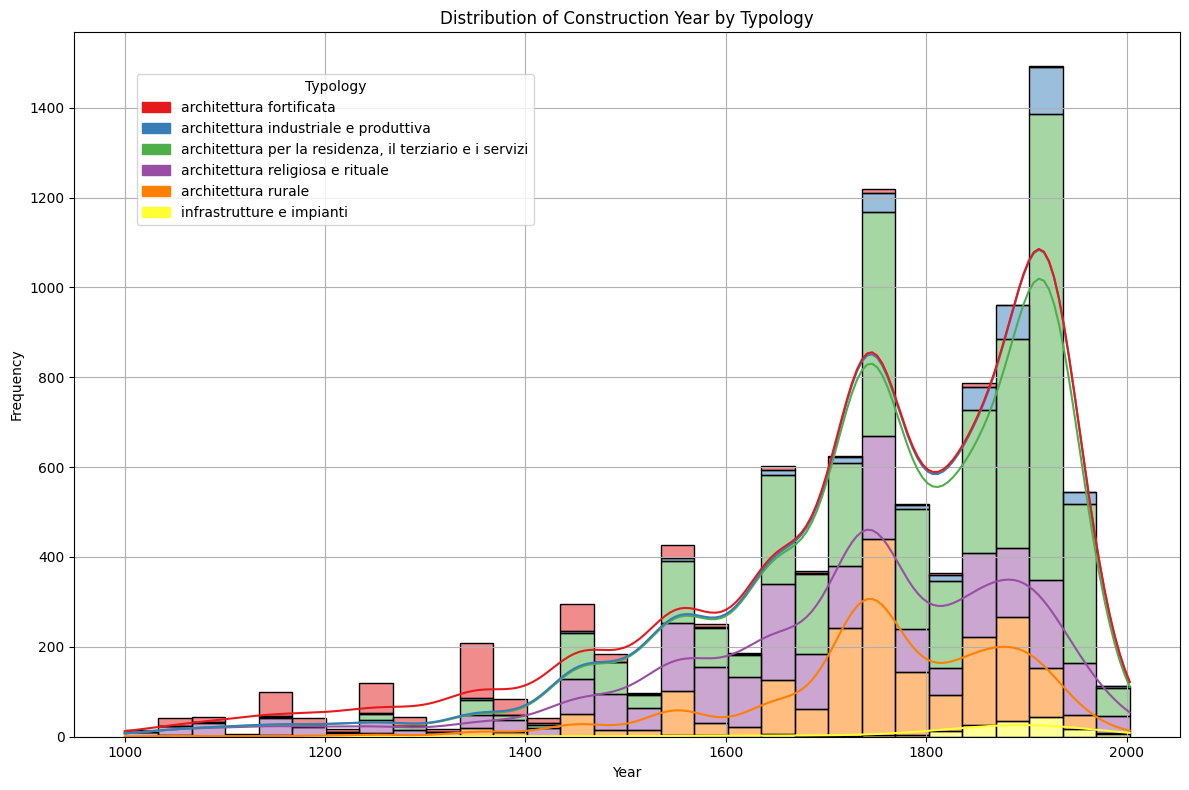

In [9]:
plt.figure(figsize=(12, 8))

# Create the histogram with 'hue' for separation by categories
sns.histplot(data=df_dates, x='date_int', hue='typology_gen', multiple='stack', kde=True, bins=30, palette="Set1")

# Add labels and title
plt.title('Distribution of Construction Year by Typology')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Get unique categories and their associated colors
unique_categories = df_dates['typology_gen'].unique()
palette = sns.color_palette("Set1", len(unique_categories))
category_color_map = dict(zip(unique_categories, palette))

# Manually create legend handles
legend_handles = [Patch(color=category_color_map[cat], label=cat) for cat in unique_categories]

# Add the legend manually
plt.legend(title='Typology', handles=legend_handles, loc='upper left', bbox_to_anchor=(0.05, 0.95))

# Display grid
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


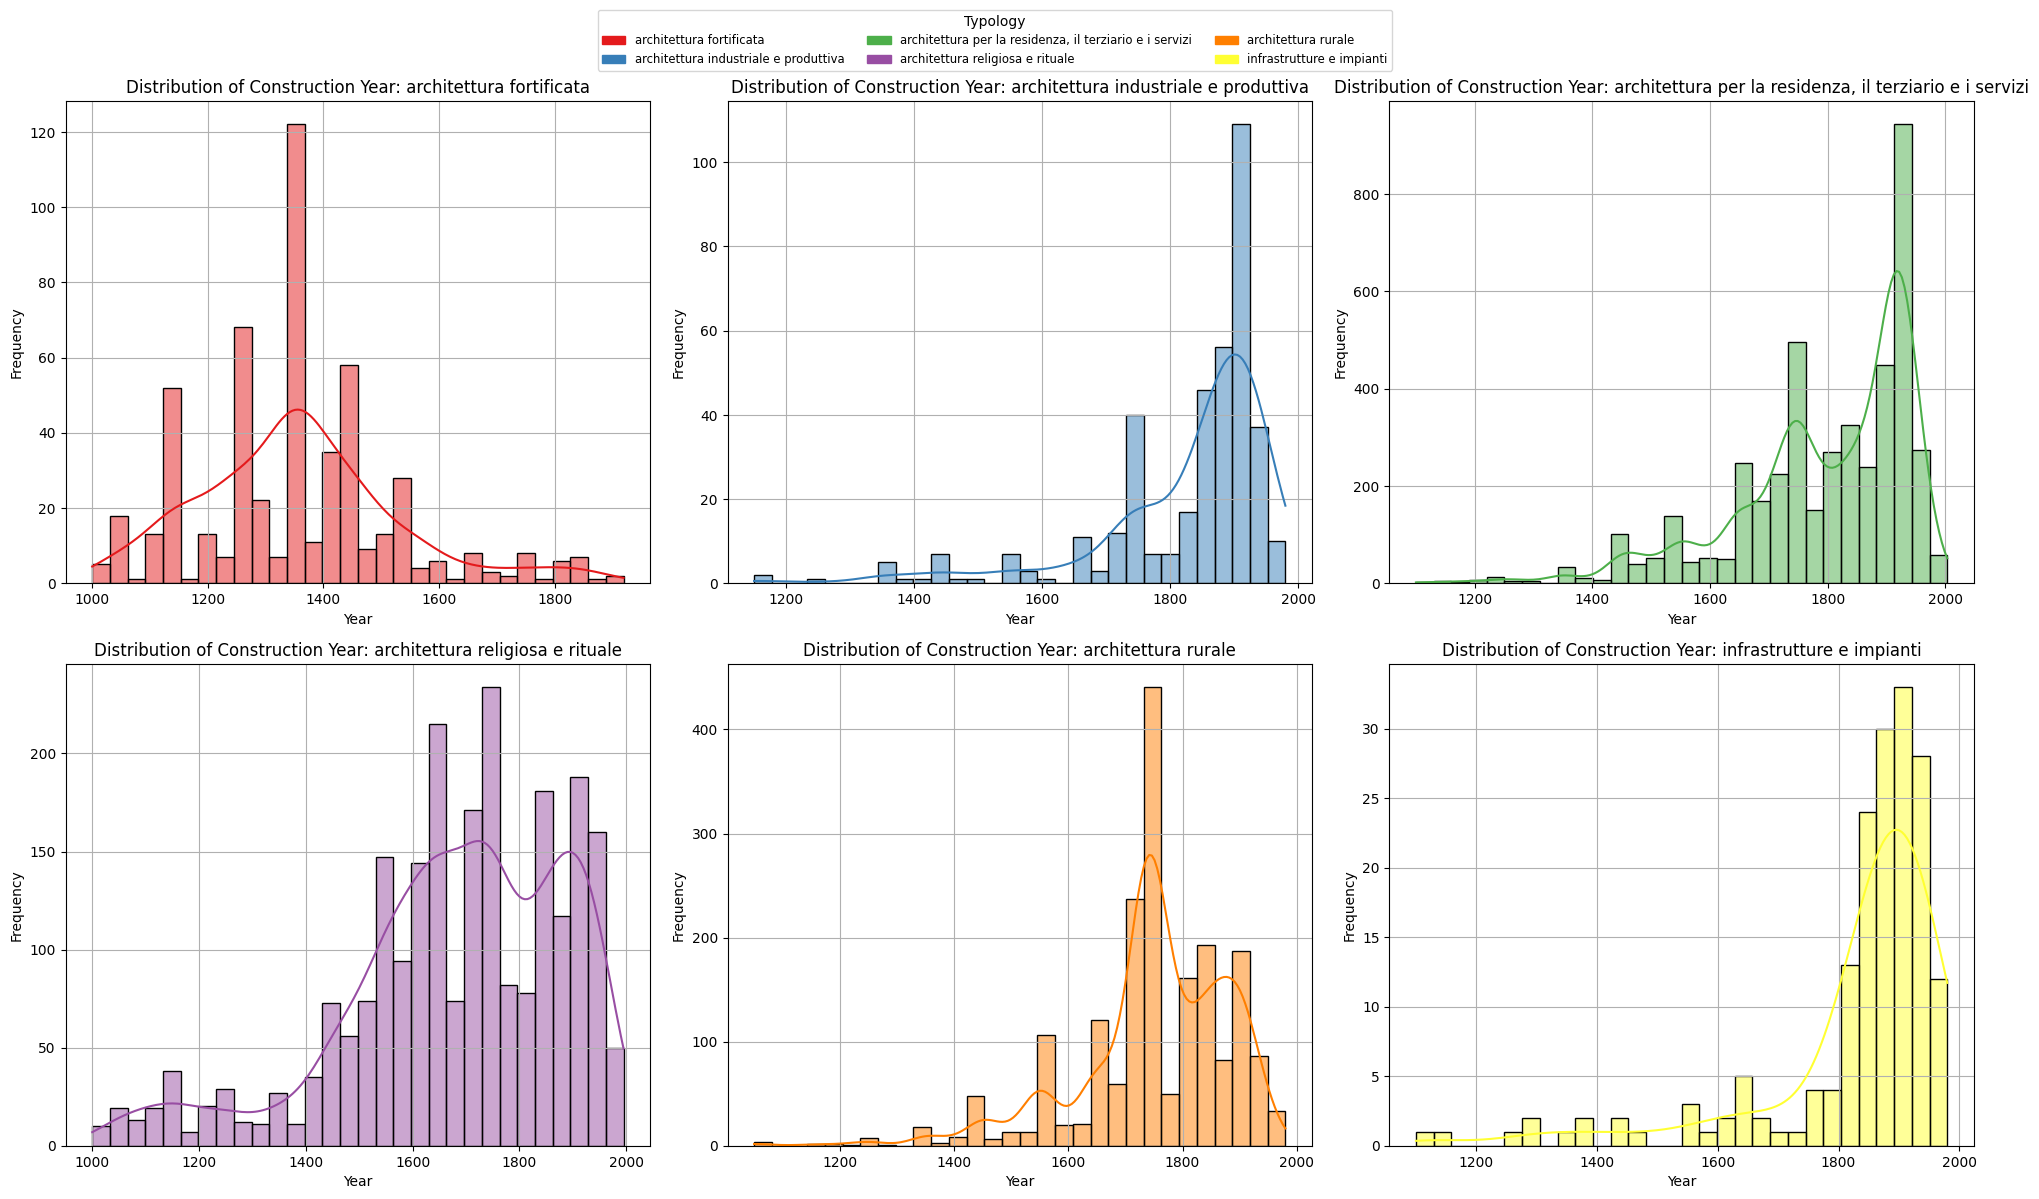

In [10]:
# Get unique categories and their associated colors
unique_categories = sorted(df_dates['typology_gen'].unique())  # Ensure consistent order
palette = sns.color_palette("Set1", len(unique_categories))
category_color_map = dict(zip(unique_categories, palette))  # Map each category to a specific color

# Create subplots (2 rows and 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=False, sharey=False)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each category in a separate subplot
for i, category in enumerate(unique_categories):
    ax = axes[i]
    sns.histplot(
        data=df_dates[df_dates['typology_gen'] == category],  # Filter data for the specific category
        x='date_int',
        kde=True,
        bins=30,
        color=category_color_map[category],
        ax=ax
    )
    ax.set_title(f'Distribution of Construction Year: {category}', fontsize=12)
    ax.set_xlabel('Year')  # Show x-axis label on all subplots
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Remove unused subplots if categories are fewer than grid spaces
for j in range(len(unique_categories), len(axes)):
    fig.delaxes(axes[j])  # Delete any unused axes

# Add a unified legend for all subplots
legend_handles = [Patch(color=category_color_map[cat], label=cat) for cat in unique_categories]
fig.legend(
    handles=legend_handles,
    title='Typology',
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    ncol=3,
    fontsize='small',
    title_fontsize='medium'
)

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend
plt.show()

# Exporting the df for the CNN training

In [11]:
df_dates.to_csv("df_dates.csv")